In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import datajoint as dj
from funconnect import connectomics as cncs, ta3, nda
from funconnect.connectomics import *
from funconnect import nda
import numpy as np
import pandas as pd
import pycircstat as circ
cncs.schema.spawn_missing_classes()

Connecting celiib@10.28.0.34:3306


# Orientation tuning

Set some parameters for the analysis

In [3]:
is_tuned = 'von_r2>0.05 and von_pvalue<0.05'
dori_resolution = np.pi / 2 / 4
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9)
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
bin_labels = list(zip(be[:-1], be[1:]))
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

Massage the relations

In [4]:
tuned_rel = nda.VonMises() & is_tuned
best_r2 = dj.U('segment_id').aggr(tuned_rel, best_r2='max(von_r2)')
pref_rel = (tuned_rel * best_r2) & 'von_r2 >= best_r2'
pref_rel




scan_idx scan ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,von_r2 r-squared explaned by vonMises fit,von_pref preferred directions,von_base von mises base value,von_amp1 amplitude of first peak,von_amp2 amplitude of second peak,von_sharp sharpnesses,von_pvalue p-value by shuffling (nShuffles = 1e4),best_r2 calculated attribute
2,1,2589588,0.053372,3.02107,0.00165716,0.0787312,0.0374586,26.5923,0.006497,0.053372
2,1,3813916,0.0578909,2.90859,0.017539,0.139912,0.0,16.2428,0.0014995,0.0578909
2,1,10914339,0.0799213,3.13328,0.0113467,0.297867,0.169138,11.2455,0.002499,0.0799213
2,1,16809519,0.236849,4.00482,0.00729216,0.537001,0.32923,19.5817,0.0005,0.236849
2,1,23410728,0.118081,2.10778,0.0550229,1.0047,0.292185,5.85615,0.0005,0.118081
2,1,27229091,0.161084,5.57486,0.00616441,0.450609,0.0902593,14.4957,0.0005,0.161084
2,1,38469670,0.198155,5.51238,0.00350638,0.232938,0.0834227,37.8783,0.0005,0.198155


In [5]:
SharedInput.describe

<bound method Table.describe of *segmentation  *segment_id    *shared_input_ *segment_b    n_seg_shared  
+------------+ +------------+ +------------+ +-----------+ +------------+
1              694582         all            421208        16            
1              694582         non-perisomati 421208        16            
1              694582         perisomatic    421208        0             
1              845222         all            421208        0             
1              845222         all            694582        0             
1              845222         non-perisomati 421208        0             
1              845222         non-perisomati 694582        0             
   ...
 (153120 tuples)
>

In [6]:
p_cond = dict(p='n_seg_shared > 0')
# p_cond = dict(p='n_seg_shared = 10')
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
#Shared Input just has 2 segments ids and how many shared inputs they have
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id')) #+ \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 
rel2 = shi  * pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref')
rel2

segment_a segment id unique within each Segmentation,connection,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments,dummy scan ID,segmentation segmentation id,scan_idx scan ID,ori_1 preferred directions,ori_2 preferred directions
2589588,non-perisomatic,53349510,0,2,1,3,3.02107,1.56219
2589588,non-perisomatic,31134493,0,2,1,5,3.02107,0.761344
2589588,perisomatic,7665318,0,2,1,6,3.02107,1.68611
2589588,perisomatic,8106120,0,2,1,5,3.02107,3.28862
2589588,all,91299685,3,2,1,2,3.02107,0.253723
2589588,all,53349510,0,2,1,3,3.02107,1.56219
2589588,all,10356289,0,2,1,6,3.02107,3.17413


Fetch the dataframe and bin the orientations

In [7]:
df = pd.DataFrame(rel2.fetch())

df['dori'] = np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2)
df['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2), bin_edges))]

df['ori_1'] = (df['ori_1'] % np.pi) * rad2deg
df['ori_2'] = (df['ori_2'] % np.pi) * rad2deg

df['bori_1'] = bin_centers[(np.digitize(df['ori_1'] % np.pi, bin_edges))-1]
df['bori_2'] = bin_centers[(np.digitize(df['ori_2'] % np.pi, bin_edges))-1]


# Plot cumulative distributions

In [8]:
stuff = ['connection', 'bdori', 'n_seg_shared']

n = df.groupby(stuff)['dummy'].count().reset_index()
s = n.groupby(stuff[:-1]).transform('sum')
cs = n.groupby(stuff[:-1]).transform('cumsum')
n['P'] = 1 - cs['dummy']/s['dummy']
n['csum'] = cs['dummy']
n['sum'] = s['dummy']
n['prob'] = n['dummy']/s['dummy']


## P(more than k shared segments| $\Delta \vartheta$)

ValueError: 'c' argument has 4 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

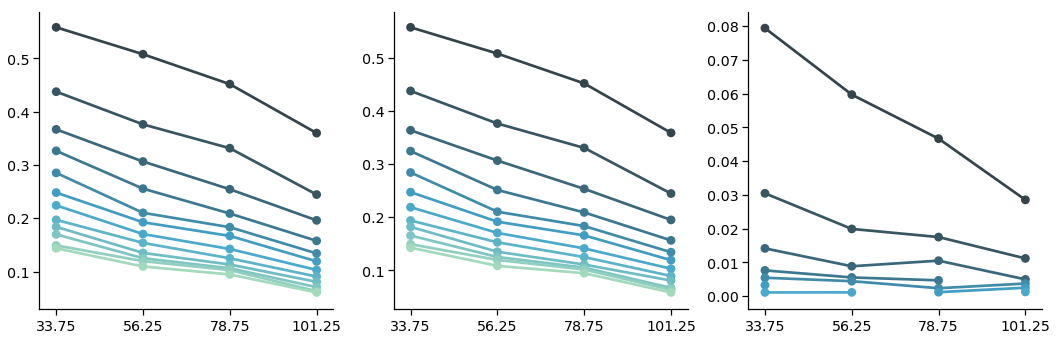

In [9]:
n['k'] = n['n_seg_shared']
sns.set_context('notebook', font_scale=1.3)
g = sns.catplot('bdori', 'P', data=n, kind='point', col='connection', hue='k', hue_order=np.arange(12), 
                palette=sns.color_palette("GnBu_d", n_colors=12), legend=False, legend_out=True, sharey=False)
g.set_titles('{col_name} axons')
g.set_axis_labels(y_var='p(number of shared segments>k)', x_var=r'$\Delta \theta$')
for ax in g.axes.ravel():
    ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
# g.axes[0,-1].legend(title='k', ncol=3)
g.add_legend(title='k', ncol=2)

sns.despine(trim=True)
g.fig.subplots_adjust(bottom=.2)
g.fig.savefig('figures/shared_input_cumprob.png', dpi=200)
g.fig.savefig('figures/shared_input_cumprob.pdf')

# $\langle$ shared segments $\rangle$ as function of $\Delta \theta$

FileNotFoundError: [Errno 2] No such file or directory: 'figures/average_shared_input.png'

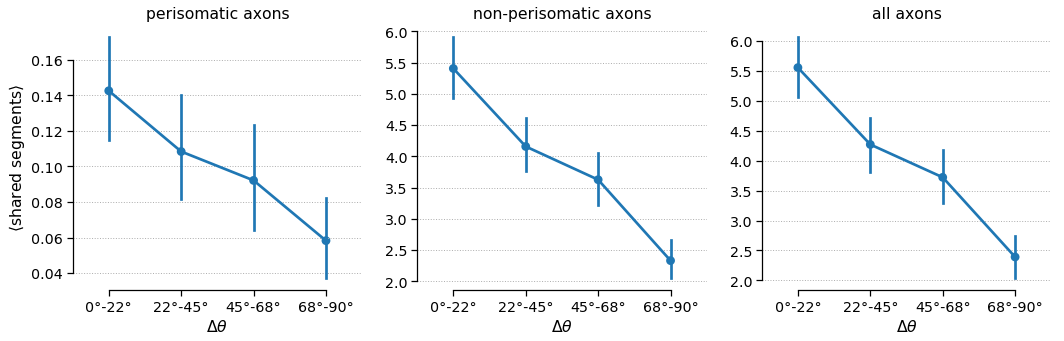

In [13]:
g = sns.catplot('bdori', 'n_seg_shared', data=df, kind='point', col='connection',  legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared segments$\rangle$')
# g.ax.set_yticks(np.arange(2,7))
# g.ax.yaxis.grid(True, linestyle=':')
for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
sns.despine(trim=True)
g.set_titles('{col_name} axons')
# g.ax.set_title('non-perisomatic axons')
g.fig.savefig('figures/average_shared_input.png', dpi=200)
g.fig.savefig('figures/average_shared_input.pdf')

# Combined plot

Get input density per postsynaptic neuron

In [ ]:
segs = ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id')
df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [ ]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

In [ ]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == 'non-perisomatic'], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# Heatmap of preferred orientation and number of shared segments

In [ ]:
df2 = df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# Receptive fields

Get significant receptive fields

In [ ]:
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6)
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]

In [ ]:
rf_scores = dj.U('segment_id').aggr(nda.RFScore(), mscore='max(score)') & good_rf

In [ ]:
# shi = (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a = 'segment_id')) + \
#       (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a='segment_b', segment_b='segment_id'))# + \
# crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
#     pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
#     rf_scores.proj(score_a='mscore', segment_a='segment_id') * rf_scores.proj(score_b='mscore', segment_b='segment_id')

Get all *tuned* neurons with *well scoring RFs* and get their pairwise shared input. 

In [ ]:
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id'))# + \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 

crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
    pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
    rf_scores.proj(segment_a='segment_id') * rf_scores.proj(segment_b='segment_id')

In [ ]:
cdf = pd.DataFrame(crel.fetch())

In [ ]:
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)



In [ ]:
cdf['dori'] = np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2) 
cdf['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2), bin_edges))]


In [ ]:
g = sns.catplot('bcorr', 'n_seg_shared', data=cdf, col='connection', kind='point', legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\rho$(RF$_1$, RF$_2$)', y_var=r'$\langle$shared segments$\rangle$')

for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(cbin_labels, rotation=30)
sns.despine(trim=True)
g.set_titles('{col_name} axons')

g.fig.savefig('figures/average_shared_input_vs_correlation.png', dpi=200)
g.fig.savefig('figures/average_shared_input_vs_correlation.pdf')

In [ ]:
g = sns.stripplot( 'n_seg_shared', 'rf_corr_coef', data=cdf[cdf.n_seg_shared < 11], jitter=0.3, s=2, color='k')
g.set_xlabel(r'number of shared presynaptic segments')
g.set_xticklabels([int(e) for e in g.get_xticks()])
g.set_ylabel(r'$\rho$(RF$_1$, RF$_2$)')
sns.despine(trim=True)
g.figure.set_size_inches((10,7))
g.figure.savefig('figures/shared_input_stripplot.png', dpi=200)
g.figure.savefig('figures/shared_input_stripplot.pdf')

In [ ]:
neg90 = cdf[(cdf.dori > 70/180*np.pi) & (cdf.rf_corr_coef > .40)]
neg90

In [ ]:
neg90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 39500491)').fetch('rf')]
neg0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (107860456, 39500491)').fetch('rf')]
pos0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (83286327, 5386310)').fetch('rf')]
pos90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 99210911)').fetch('rf')]

In [ ]:
from itertools import chain
gs = plt.GridSpec(4, 4)
fig = plt.figure(figsize=(15,7.5))
ax_heat = fig.add_subplot(gs[:,1:3])
with sns.axes_style('whitegrid'):
    ax_tl = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
    ax_tr = [fig.add_subplot(gs[0,-1]), fig.add_subplot(gs[1,-1])]
    ax_br = [fig.add_subplot(gs[-2,-1]), fig.add_subplot(gs[-1,-1])]
    ax_bl = [fig.add_subplot(gs[-2,0]), fig.add_subplot(gs[-1,0])]

for tl, rf in chain(zip(ax_tl, neg90), zip(ax_bl, neg0), zip(ax_br, pos0),  zip(ax_tr, pos90)):
    rf -= rf.mean()
    v = np.abs(rf).max()
#     tl.contour(rf, cmap='bwr', levels=np.linspace(-v,v,7))
    tl.matshow(rf, cmap='bwr', vmin=-v, vmax=v)
    tl.set_xticklabels([])
    tl.set_yticklabels([])
    tl.tick_params(axis='both', length=0, width=0)

    
    
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()

df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2, ax=ax_heat)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
g.set_xticklabels(cbin_labels, rotation=30)
g.invert_yaxis()
g.tick_params(length=0)
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

fig.subplots_adjust(wspace=.01, hspace=.01)
fig.tight_layout()
g.figure.savefig('figures/corr_vs_shared_input_heatmap.png', dpi=200)
g.figure.savefig('figures/corr_vs_shared_input_heatmap.pdf')


In [ ]:
g = sns.catplot('bdori', 'n_seg_shared', hue='bcorr', kind='bar', palette=sns.color_palette('GnBu', n_colors=5), data=cdf, legend=False)
g.add_legend(prop={'size':12})
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared axons$\rangle$')
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
new_labels = cbin_labels
g._legend.set_title(r'$\rho$(RF$_1$, RF$_2$)')
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)

sns.despine()
g.fig.savefig('figures/corr_vs_shared_input_bar.png', dpi=200)
g.fig.savefig('figures/corr_vs_shared_input_bar.pdf')